In [1]:
import collections
import time

import numpy as np
import pandas as pd

# import tensorflow.compat.v1 as tf
# tf.disable_eager_execution()
from tensorflow.python.training import adagrad
import tensorflow.compat.v1.keras.backend
import shap

from ciml import gather_results
from ciml import tf_trainer

In [2]:
# Dataset, experiment and model for the CIML Data
data_path = '/Users/kw/ciml_data/cimlodsceu2019seed'
dataset = 'usr_1m-1min-status'
experiment = 'dnn-5x100-500epochs-bs128'
model_dir = gather_results.get_model_folder(dataset, experiment)

In [3]:
# Load the experiment data
experiment_data = gather_results.load_experiment(
        experiment, data_path=data_path)

In [4]:
# Load Data
training_data = gather_results.load_dataset(dataset, 'training', data_path=data_path)
test_data = gather_results.load_dataset(dataset, 'test', data_path=data_path)
labels = gather_results.load_dataset(dataset, 'labels', data_path=data_path)['labels']

X_train = training_data['examples']
Y_train = training_data['classes']
X_train_red = shap.sample(X_train, 100)
X_test = test_data['examples']
Y_test = test_data['classes']
X_test_red = shap.sample(X_test, 100)

# Helper to display accuracy from the dataset
def print_accuracy(f):
    print("Accuracy = {0}%".format(100*np.sum(f(X_test) == Y_test)/len(Y_test)))
    time.sleep(0.5) # to let the print get out before any progress bars

shap.initjs()

In [5]:
# Create the estimator
estimator = experiment_data['estimator']
hyper_params = experiment_data['hyper_params']
params = experiment_data['params']
steps = int(hyper_params['steps'])
num_epochs = int(hyper_params['epochs'])
batch_size = int(hyper_params['batch_size'])
optimizer = hyper_params['optimizer']
learning_rate = float(hyper_params['learning_rate'])
label_vocabulary = None

estimator = tf_trainer.get_estimator(
        estimator, hyper_params, params, labels, model_dir,
        optimizer=adagrad.AdagradOptimizer(learning_rate=0.05),
        label_vocabulary=label_vocabulary, gpu=False)

INFO:tensorflow:Using config: {'_model_dir': '/git/github.com/mtreinish/ciml/ciml/../data/usr_1m-1min-status/dnn-5x100-500epochs-bs128', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 300, '_session_config': allow_soft_placement: true
, '_keep_checkpoint_max': 10, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [6]:
# Prepare the input function
input_fn=tf_trainer.get_input_fn(shuffle=True,
                    batch_size=batch_size, num_epochs=num_epochs,
                    labels=labels, **training_data)

In [7]:
# Run the training
training_result = tf_trainer.get_training_method(estimator)(
                    input_fn=tf_trainer.get_input_fn(shuffle=True,
                    batch_size=batch_size, num_epochs=num_epochs,
                    labels=labels, **training_data), steps=steps)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
Call initializer instance with the dtype argument

INFO:tensorflow:global_step/sec: 28.5792
INFO:tensorflow:loss = 2.6132517e-05, step = 4600 (3.501 sec)
INFO:tensorflow:global_step/sec: 24.8531
INFO:tensorflow:loss = 7.502634e-05, step = 4700 (4.026 sec)
INFO:tensorflow:global_step/sec: 26.579
INFO:tensorflow:loss = 2.8406417e-05, step = 4800 (3.759 sec)
INFO:tensorflow:global_step/sec: 24.1969
INFO:tensorflow:loss = 7.240918e-05, step = 4900 (4.138 sec)
INFO:tensorflow:global_step/sec: 25.8445
INFO:tensorflow:loss = 7.380023e-05, step = 5000 (3.869 sec)
INFO:tensorflow:global_step/sec: 24.9491
INFO:tensorflow:loss = 8.278723e-05, step = 5100 (4.006 sec)
INFO:tensorflow:global_step/sec: 19.2785
INFO:tensorflow:loss = 5.918819e-05, step = 5200 (5.186 sec)
INFO:tensorflow:global_step/sec: 24.9271
INFO:tensorflow:loss = 0.00011721375, step = 5300 (4.011 sec)
INFO:tensorflow:global_step/sec: 25.2442
INFO:tensorflow:loss = 0.00019873903, step = 5400 (3.963 sec)
INFO:tensorflow:global_step/sec: 25.6355
INFO:tensorflow:loss = 3.802895e-05, s

In [8]:
# Build a prediction function suitable for the KernelExplainer
def model_fn(data):
    output = estimator.predict(tf_trainer.get_input_fn(
        examples=data, example_ids=None, classes=None, labels=labels,
        batch_size=128, num_epochs=1))
    return np.array([int(x['classes']) for x in output])

In [9]:
# Verify the function fits our data
result = model_fn(X_train_red)
result

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m-1min-status/dnn-5x100-500epochs-bs128/model.ckpt-9286
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [10]:
# Run the explainer
print_accuracy(model_fn)

explainer = shap.KernelExplainer(model_fn, X_train_red)
shap_values = explainer.shap_values(X_test_red)

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m-1min-status/dnn-5x100-500epochs-bs128/model.ckpt-9286
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy = 98.11083123425692%
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this war

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m-1min-status/dnn-5x100-500epochs-bs128/model.ckpt-9286
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue i

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m-1min-status/dnn-5x100-500epochs-bs128/model.ckpt-9286
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you 

INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m-1min-status/dnn-5x100-500epochs-bs128/model.ckpt-9286
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m-1min-status/dnn-5x100-500epochs-bs128/model.ckpt-9286
INFO:tensorflow:Runni

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m-1min-status/dnn-5x100-500epochs-bs128/model.ckpt-9286
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m-1min-status/dnn-5x100-500epochs-bs128/model.ckpt-9286
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m-1min-status/dnn-5x100-500epochs-bs128/model.ckpt-9286
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m-1min-status/dnn-5x100-500epochs-bs128/model.ckpt-9286
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m-1min-status/dnn-5x100-500epochs-bs128/model.ckpt-9286
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m-1min-status/dnn-5x100-500epochs-bs128/model.ckpt-9286
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m-1min-status/dnn-5x100-500epochs-bs128/model.ckpt-9286
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m-1min-status/dnn-5x100-500epochs-bs128/model.ckpt-9286
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m-1min-status/dnn-5x100-500epochs-bs128/model.ckpt-9286
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m-1min-status/dnn-5x100-500epochs-bs128/model.ckpt-9286
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m-1min-status/dnn-5x100-500epochs-bs128/model.ckpt-9286
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m-1min-status/dnn-5x100-500epochs-bs128/model.ckpt-9286
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m-1min-status/dnn-5x100-500epochs-bs128/model.ckpt-9286
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m-1min-status/dnn-5x100-500epochs-bs128/model.ckpt-9286
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m-1min-status/dnn-5x100-500epochs-bs128/model.ckpt-9286
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m-1min-status/dnn-5x100-500epochs-bs128/model.ckpt-9286
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m-1min-status/dnn-5x100-500epochs-bs128/model.ckpt-9286
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m-1min-status/dnn-5x100-500epochs-bs128/model.ckpt-9286
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m-1min-status/dnn-5x100-500epochs-bs128/model.ckpt-9286
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m-1min-status/dnn-5x100-500epochs-bs128/model.ckpt-9286
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m-1min-status/dnn-5x100-500epochs-bs128/model.ckpt-9286
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m-1min-status/dnn-5x100-500epochs-bs128/model.ckpt-9286
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /git/github.com/mtreinish/ciml/ciml/../data/usr_1m-1min-status/dnn-5x100-500epochs-bs128/model.ckpt-9286
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.



TypeError: 'float' object is not subscriptable

In [11]:
shap.force_plot(explainer.expected_value, shap_values, X_test_red)

In [12]:
shap_values.shape

(100, 184)

In [13]:
X_test_red.shape

(100, 184)

In [14]:
np.savez_compressed("shap_values.npz", shap_values=shap_values, X_test_red=X_test_red, expected_value=explainer.expected_value, labels=labels)

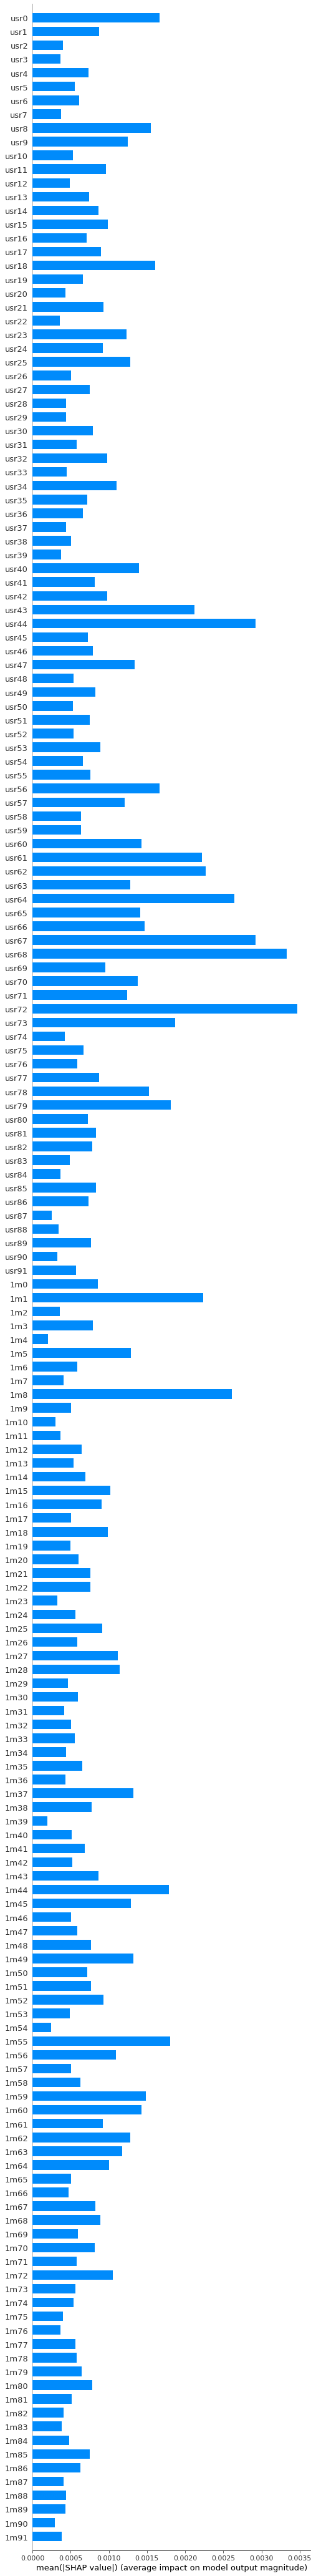

In [15]:
shap.summary_plot(shap_values, X_test_red, feature_names=labels, plot_type="bar", max_display=184, sort=False)